# HyperCAT  Interferometry module

This notebook shows examples on how to use the interferometry module of HyperCAT. You will find here the general worksflow to obtain simulated interferomeric observations for a given AGN torus and uv plane defined byt he user.

In [1]:
# IMPORTS
import hypercat as hc
import interferometry as inter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ioops as io
from astropy.modeling import models

In [ ]:
#For more information about to select subcubes and make a source check the hypercat_workflow.ipynb notebook.

# Load a sub-cube into RAM
hdf5file = '/Volumes/Seagate Backup Plus Drive/hypercat/hypercat_20170109.hdf5'
cube = hc.ModelCube(hdffile=hdf5file,hypercube='imgdata',subcube_selection='../examples/democube.json')

#Make a source
ngc1068 = hc.Source(cube,luminosity='2e45 erg/s',distance='14 Mpc',name='ngc1068',pa='42 deg')  

#Select a clumpy torus image and wavelength. Assuming a flux density of 2500 mJy at 8.5 microns.
i = 88
N = 5
q = 0
wave = 8.0
theta = (i,N,q,wave)
sky = ngc1068(theta,total_flux_density='2500 mJy')

In [2]:
### Check with Gaussian
# to check the functions a Gaussian is used. The 2D Gaussian named 'ori' should be the 2D clumpy image.
g   = models.Gaussian2D(amplitude=100, x_mean=0, y_mean=0, x_stddev=0.5, y_stddev=0.5, theta=0)

xx = np.linspace(-10,10,100)
x,y = np.meshgrid(xx,xx)

ori = g(x,y) 

#Create 2D FFT of clumpy torus image
ori_fft = inter.ima2fft(ori)
#Obtain pixel scale
fftscale = inter.fft_pxscale(ori)
#Obtain uv points
filename = '../examples/Circinus_clean.oifits' 
u,v = inter.uvload(filename)
#obtain baseline and position angles in 1D
BL, Phi = inter.baseline_phase_1D(u,v)
#Obtain uv plane in pixels
u_px,v_px = inter.uvfreq2uvpixel(u,v,fftscale)
#Obtain correlated flux 2D
corrflux2D, BL2D, Phi2D = inter.correlatedflux2D(ori_fft,u_px,v_px,BL,Phi)
#Obtain correlated flux 1D
corrflux1D = inter.correlatedflux1D(corrflux2D)

Pixel scale in FFT image is:  2.52064552972  m (Baseline) per pixel


interferometry.py:247: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a[uu,vv] = 1.
interferometry.py:248: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  BL2D[uu,vv] = BL[ii]
interferometry.py:249: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Phi2D[uu,vv] = Phi[ii]


(0.00045223028634193462, 2844.7787261588956)

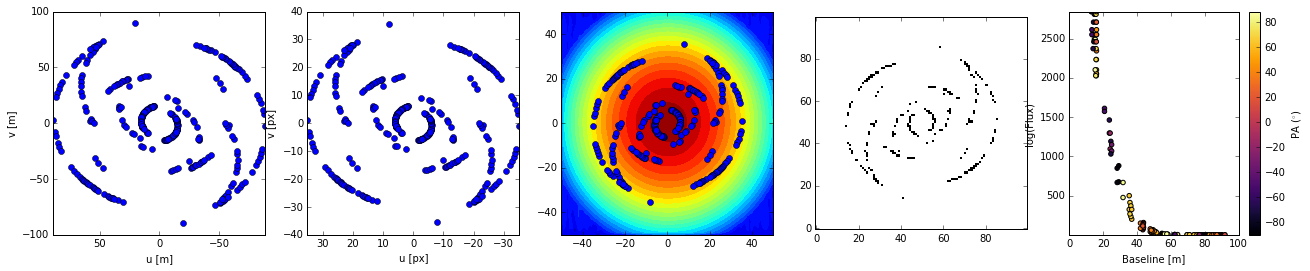

In [6]:
#Plots

fig1, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(22,4))

ax1.plot(u,v,'o')
ax1.set_xlabel('u [m]')
ax1.set_xlim([np.max(u),np.min(u)])
ax1.set_ylabel('v [m]')

ax2.plot(u_px,v_px,'o')
ax2.set_xlabel('u [px]')
ax2.set_xlim([np.max(u_px),np.min(u_px)])
ax2.set_ylabel('v [px]')

x = np.linspace(-ori_fft.shape[0]/2,ori_fft.shape[0]/2,ori_fft.shape[0])

ax3.contourf(x,x,np.log10(ori_fft),31)
ax3.plot(u_px,v_px,'o')

ax4.imshow(corrflux2D,interpolation='Nearest',origin='lower',cmap='gray_r',vmin=0,vmax=0.0000001)

BL = np.linspace(0,len(corrflux1D),len(corrflux1D))
n_good = np.where(corrflux2D > 0)
plot = ax5.scatter(BL2D[n_good], corrflux2D[n_good], c = Phi2D[n_good], cmap = 'inferno')
plt.colorbar(plot,label='PA ($^{\\circ}$)',ax=ax5)
#ax5.set_yscale('log')
ax5.set_ylabel('log(Flux)')
ax5.set_xlabel('Baseline [m]')
ax5.set_ylim([np.min(corrflux2D[n_good])*2,np.max(corrflux2D[n_good])])

# Circinus: 3 Gaussian example

In [30]:
### Defining Gaussians
g1  = models.Gaussian2D(amplitude=1, x_mean=0, y_mean=0, x_stddev=1, y_stddev=0.16, theta=46)

g2  = models.Gaussian2D(amplitude=2, x_mean=0, y_mean=0, x_stddev=1, y_stddev=0.45, theta=107)

g3  = models.Gaussian2D(amplitude=1, x_mean=-0.5, y_mean=1, x_stddev=0.5, y_stddev=.5, theta=0)

xx = np.linspace(-10,10,100)
x,y = np.meshgrid(xx,xx)

ori = g1(x,y) + g2(x,y) + g3(x,y)
####

In [31]:
#### Interferometry routines by HyperCAT

#Create 2D FFT of clumpy torus image
ori_fft = inter.ima2fft(ori)
#Obtain pixel scale
fftscale = inter.fft_pxscale(ori)
#Obtain uv points
filename = '../examples/Circinus_clean.oifits' 
u,v = inter.uvload(filename)
#obtain baseline and position angles in 1D
BL, Phi = inter.baseline_phase_1D(u,v)
#Obtain uv plane in pixels
u_px,v_px = inter.uvfreq2uvpixel(u,v,fftscale)
#Obtain correlated flux 2D
corrflux2D, BL2D, Phi2D = inter.correlatedflux2D(ori_fft,u_px,v_px,BL,Phi)
#Obtain correlated flux 1D
corrflux1D = inter.correlatedflux1D(corrflux2D)

Pixel scale in FFT image is:  2.52064552972  m (Baseline) per pixel


(4.4884617458021977e-06, 104.95435400291045)

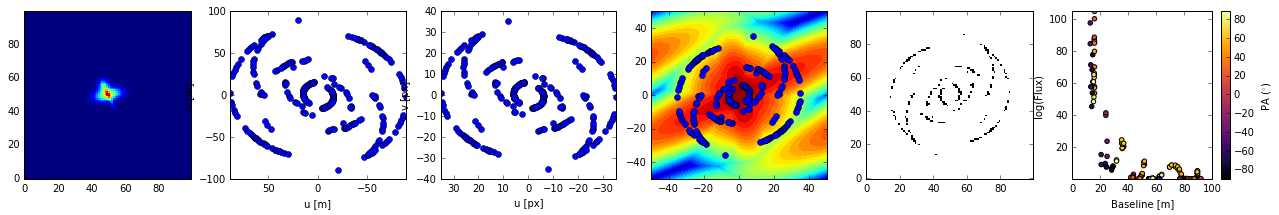

In [32]:
#Plots
fig1, (ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,6,figsize=(22,3))

ax0.imshow(ori,origin='lower',interpolation='Nearest')


ax1.plot(u,v,'o')
ax1.set_xlabel('u [m]')
ax1.set_xlim([np.max(u),np.min(u)])
ax1.set_ylabel('v [m]')

ax2.plot(u_px,v_px,'o')
ax2.set_xlabel('u [px]')
ax2.set_xlim([np.max(u_px),np.min(u_px)])
ax2.set_ylabel('v [px]')

x = np.linspace(-ori_fft.shape[0]/2,ori_fft.shape[0]/2,ori_fft.shape[0])

ax3.contourf(x,x,np.log10(ori_fft),31)
ax3.plot(u_px,v_px,'o')

ax4.imshow(corrflux2D,interpolation='Nearest',origin='lower',cmap='gray_r',vmin=0,vmax=0.0000001)

BL = np.linspace(0,len(corrflux1D),len(corrflux1D))
n_good = np.where(corrflux2D > 0)
plot = ax5.scatter(BL2D[n_good], corrflux2D[n_good], c = Phi2D[n_good], cmap = 'inferno')
plt.colorbar(plot,label='PA ($^{\\circ}$)',ax=ax5)
#ax5.set_yscale('log')
ax5.set_ylabel('log(Flux)')
ax5.set_xlabel('Baseline [m]')
ax5.set_ylim([np.min(corrflux2D[n_good])*2,np.max(corrflux2D[n_good])])